In TensorFlow, you have to create a graph and run it within a session in order to execute the operations of the graph. Eager Execution (EE) enables you to run operations directly and inspect the output as the operations are executed.

EE is greate for prototyping, is pythonic and intergrates pretty well with Numpy so it makes programming really easy and flexible. TensorFlow 2.0 will enable EE by default.


In [33]:
import matplotlib.pyplot as plt

## Enable eager execution

In [1]:
import tensorflow as tf
tf.enable_eager_execution()

## Executing Ops Eagerly
By perfoming operations you can see the output directly without creating a session.

In [2]:
x = [[2.]]
m = tf.square(x)
print(m)

# Convert tensor to Numpy array
print(type(m.numpy()))

tf.Tensor([[4.]], shape=(1, 1), dtype=float32)
<class 'numpy.ndarray'>


Compute an operation including two tensors

In [3]:
a = tf.constant([[1, 2],
                 [3, 4]])

b = tf.constant([[2, 1],
                 [3, 4]])

ab = tf.matmul(a, b)

print(ab.numpy())

[[ 8  9]
 [18 19]]


## Constants and Variables
 * tf.constant, creates a constant tensor populated with the values as argument. The values are immutable.
 * tf.Variable, this method encapsultes a mutable tensor that can be changed later using assign

In [4]:
a = tf.constant([[2,3]])
print(a)

# A constant is immutable, you cannot assign a new value to it
try:
  a.assign([[3,4]])
except:
  print('Exception raised ')

tf.Tensor([[2 3]], shape=(1, 2), dtype=int32)
Exception raised 


In [5]:
# Variables are mutable and can be assigned a new value
v = tf.Variable(5.)

print('Old value for v =', v.numpy())
v.assign(2.)
print('New value for v =', v.numpy())

Old value for v = 5.0
New value for v = 2.0


You can increment/decrement the value of a tensor

In [6]:
v.assign(2.)
print('value     : ', v.numpy())
print('increment : ', tf.assign_add(v, 1).numpy())
print('decrement : ', tf.assign_sub(v, 1).numpy())

value     :  2.0
increment :  3.0
decrement :  2.0


A tensor has name, type, shape and device properties.

In [7]:
print('name  : ', v.name)
print('type  : ', v.dtype)
print('shape : ', v.shape)
print('device: ', v.device)

name  :  Variable:0
type  :  <dtype: 'float32'>
shape :  ()
device:  /job:localhost/replica:0/task:0/device:CPU:0


Tensors defined with eager execution are not attached to the (default) Graph.

In [8]:
for op in tf.get_default_graph().get_operations():
    print(op)

## Gradient Evaluation
You can use tf.GradientTape() method to record the gradient of an arbitrary function

In [9]:
w = tf.Variable(2.0)

#watch the gradient of the loss operation
with tf.GradientTape() as tape:
  loss = 0.5 * w**3

grad = tape.gradient(loss, w)
print(f'The gradient of loss at {w.numpy()} is {grad.numpy()}')

Instructions for updating:
Colocations handled automatically by placer.
The gradient of loss at 2.0 is 6.0


You also compute the gradient directly using `gradients_function`. 

In [10]:
import tensorflow.contrib.eager as tfe 

def loss(w):
    return 0.5 * w**3
grad_loss = tfe.gradients_function(loss)
grad_loss(2.0)[0].numpy()

6.0

In this example we evaluate the gradient of the sigmoid function:

$$f(x) = \frac{1}{1+e^{-x}}$$

$$f'(x) = \frac{e^{-x}}{(1+e^{-x})^2} = f(x)(1-f(x)) $$

In [11]:
def sigmoid(x):
    return 1/(1 + tf.exp(-x))

grad_sigmoid = tfe.gradients_function(sigmoid)

print('The gradient of the sigmoid function at 2.0 is ', grad_sigmoid(2.0)[0].numpy())

The gradient of the sigmoid function at 2.0 is  0.104993574


Higher order derivatives can be computed by nesting gradient functions:

$$f(x) = \log(x) , f'(x) = \frac{1}{x}, f''(x) = \frac{-1}{x^2}$$

In [12]:
dx = tfe.gradients_function

def log(x):
    return tf.log(x)

dx_log = dx(log)
dx2_log = dx(dx(log))
dx3_log = dx(dx(dx(log)))

print('The first  derivative of log at x = 1 is ', dx_log(1.)[0].numpy())
print('The second derivative of log at x = 1 is ', dx2_log(1.)[0].numpy())
print('The third  derivative of log at x = 1 is ', dx3_log(1.)[0].numpy())

The first  derivative of log at x = 1 is  1.0
The second derivative of log at x = 1 is  -1.0
The third  derivative of log at x = 1 is  2.0


## Custom Gradients

Some times the gradient is not what we want especially if there is a problem in numerical instabilitiy. Consider the following function and its gradient 

$$f(x) = \log(1+e^x)$$

The gradient is 

$$f'(x) = \frac{e^x}{1+e^x}$$

Note that at big values of $x$ the gradient value will blow up.

In [16]:
def logexp(x):
    return tf.log(1 + tf.exp(x))
grad_logexp = tfe.gradients_function(logexp)

print('The gradient at x = 0  is ', grad_logexp(0.)[0].numpy())  

print('The gradient at x = 100 is ', grad_logexp(100.)[0].numpy()) 

The gradient at x = 0  is  0.5
The gradient at x = 100 is  nan


 We can revaluate the gradient by overriding the gradient of the function. We can recompute the gradient as 

$$f(x) =  \frac{1+e^x -e^x }{1+e^x} = 1 - \frac{1}{1 + e^{x}}$$

In [18]:
@tf.custom_gradient
def logexp_stable(x):
    e = tf.exp(x)
    #dy is optional, allows computation of vector jacobian products for vectors other than the vector of ones.
    def grad(dy):
        return dy * (1 - 1 / (1 + e))
    return tf.log(1 + e), grad

grad_logexp_stable = tfe.gradients_function(logexp_stable)

print('The gradient at x = 100 is ', grad_logexp_stable(100.)[0].numpy()) 

The gradient at x = 100 is  1.0


## Execution callbacks

`add_execution_callback` can be used to monitor the execution of operations. These functions will be called when any function is executed eagerly. In this example we record the operation names.

In [20]:
# create a callback that records the operation name 
def print_op(op_type, op_name, attrs, inputs, outputs):
    print(op_type)

tfe.clear_execution_callbacks() 

# add a callback 
tfe.add_execution_callback(print_op)

# run the operation
x = tf.pow(2.0, 3.0) - 3.0

tfe.clear_execution_callbacks() 

Pow
Sub


## Linear Regression 

This example is refactored from https://www.tensorflow.org/guide/eager. We create a complete example of using linear regression to predict the paramters of the function 

$$f(x) = 3 x + 2 + noise$$

Given a point $x$ we want to predict the value of $y$. We train the model on 1000 data pairs $(x,f(x))$. 

The model to learn is a linear model 

$$\hat{y} = W x + b$$

Note that, we use `tf.GradientTape` to record the gradient with respect our trainable paramters.  

We MSE to calcuate the loss 

$$g = (y-\hat{y})^2$$

We use Gradient Descent to update the paramters 

$$W = W - \alpha  \frac{\partial g}{\partial W}$$

$$b = b - \alpha  \frac{\partial g}{\partial b}$$

In [23]:
#1000 data points 
NUM_EXAMPLES = 1000

#define inputs and outputs with some noise 
X = tf.random_normal([NUM_EXAMPLES])  #inputs 
noise = tf.random_normal([NUM_EXAMPLES]) #noise 
y = X * 3 + 2 + noise  #true output

#create model paramters with initial values 
W = tf.Variable(0.)
b = tf.Variable(0.)

#training info
train_steps = 200
learning_rate = 0.01

for i in range(train_steps):
  
    #watch the gradient flow 
    with tf.GradientTape() as tape:
    
        #forward pass 
        yhat = X * W + b

        #calcuate the loss (difference squared error)
        error = yhat - y
        loss = tf.reduce_mean(tf.square(error))
  
    #evalute the gradient with the respect to the paramters
    dW, db = tape.gradient(loss, [W, b])

    #update the paramters using Gradient Descent  
    W.assign_sub(dW * learning_rate)
    b.assign_sub(db* learning_rate)

    #print the loss every 20 iterations 
    if i % 20 == 0:
        print("Loss at step {:03d}: {:.3f}".format(i, loss))
      
print(f'W : {W.numpy()} , b  = {b.numpy()} ')

Loss at step 000: 13.434
Loss at step 020: 6.684
Loss at step 040: 3.593
Loss at step 060: 2.178
Loss at step 080: 1.529
Loss at step 100: 1.232
Loss at step 120: 1.096
Loss at step 140: 1.034
Loss at step 160: 1.006
Loss at step 180: 0.993
W : 2.9493610858917236 , b  = 1.9152379035949707 


## Simple CNN model
Build the model:

In [26]:
from tensorflow.keras.layers import Dense, Convolution2D, MaxPooling2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential

def create_model():
    model = Sequential()
    model.add(Convolution2D(filters = 16, kernel_size = 3, padding = 'same', input_shape = [28, 28, 1], activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(BatchNormalization())
    model.add(Convolution2D(filters = 32, kernel_size = 3, padding = 'same', activation = 'relu'))
    model.add(MaxPooling2D(pool_size = (2,2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(units = 100, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(units = 10 , activation = 'softmax'))
    return model

model = create_model()
model.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 14, 14, 16)        64        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
batch_normalization_v1_1 (Ba (None, 7, 7, 32)          128       
___________________________

Use the model to generate predictions on some fake data:

In [30]:
import numpy as np
preds = model(np.zeros((5, 28, 28, 1), np.float32))
preds.numpy()

array([[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1],
       [0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1]], dtype=float32)

Load dataset

The label is  5


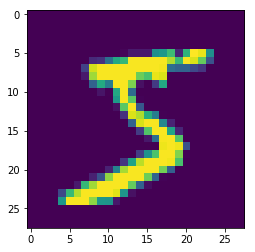

In [45]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
print('The label is ',y_train[0])
plt.imshow(x_train[0])
plt.show()

In [46]:
import numpy as np

N = x_train.shape[0]

# normalization and add channel dimension
x_train = tf.expand_dims(np.float32(x_train)/ 255., 3)
x_test  = tf.expand_dims(np.float32(x_test )/ 255., 3)

# one hot encoding
y_train = tf.one_hot(y_train, 10)
y_test  = tf.one_hot(y_test , 10)

In [47]:
import numpy as np
def get_batch(batch_size = 32):
    r = np.random.randint(0, N-batch_size)
    return x_train[r: r + batch_size], y_train[r: r + batch_size]

Define loss, gradient and metrics

In [48]:
# evaluate the loss
def loss(model, x, y):
    prediction = model(x)
    return tf.losses.softmax_cross_entropy(y, logits=prediction)

# record the gradient with respect to the model variables 
def grad(model, x, y):
    with tf.GradientTape() as tape:
        loss_value = loss(model, x, y)
    return tape.gradient(loss_value, model.variables)

# calcuate the accuracy of the model 
def accuracy(model, x, y):
  
    # prediction
    yhat = model(x)
  
    # get the labels of the predicted values 
    yhat = tf.argmax(yhat, 1).numpy()
  
    # get the labels of the true values
    y    = tf.argmax(y   , 1).numpy()
    return np.sum(y == yhat)/len(y)

Initialize variables

In [49]:
i = 1 

batch_size = 64 
epoch_length = N // batch_size
epoch = 0 
epochs = 5 

#use Adam optimizer 
optimizer = tf.train.AdamOptimizer()

#record epoch loss and accuracy  
loss_history = tfe.metrics.Mean("loss")
accuracy_history = tfe.metrics.Mean("accuracy")

Train the model

In [50]:
while epoch < epochs:
  # get next batch
  x, y = get_batch(batch_size = batch_size)

  # Calculate derivatives of the input function with respect to its parameters.
  grads = grad(model, x, y)

  # Apply the gradient to the model
  optimizer.apply_gradients(zip(grads, model.variables),
                            global_step=tf.train.get_or_create_global_step())
  
  #record the current loss and accuracy   
  loss_history(loss(model, x, y))
  accuracy_history(accuracy(model, x, y))
  
  if i % epoch_length == 0:
    print("epoch: {:d} Loss: {:.3f}, Acc: {:.3f}".format(epoch, loss_history.result(), accuracy_history.result()))
    
    #clear the history 
    loss_history.init_variables()
    accuracy_history.init_variables()
    
    epoch += 1
    
  i += 1

Instructions for updating:
Use tf.cast instead.
epoch: 0 Loss: 1.541, Acc: 0.929
epoch: 1 Loss: 1.484, Acc: 0.979
epoch: 2 Loss: 1.476, Acc: 0.986
epoch: 3 Loss: 1.472, Acc: 0.990
epoch: 4 Loss: 1.471, Acc: 0.991


Test the model

In [ ]:
accuracy(model, x_test, y_test)

Save model

In [ ]:
# create a directory for saving the model
import os 
checkpoint_dir = 'model'
os.mkdir(checkpoint_dir)

# create a root for the checkpoint
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
root = tf.train.Checkpoint(optimizer=optimizer,
                           model=model,
                           optimizer_step=tf.train.get_or_create_global_step())

# save the model 
root.save(file_prefix=checkpoint_prefix)

Restore model

In [ ]:
#create an empty model 
model = create_model()

#accuracy of the empty model 
print('accuracy before retrieving the model ',accuracy(model, x_test, y_test))

#create a checkpoint variable 
root = tf.train.Checkpoint(optimizer=optimizer,
                           model=create_model(),
                           optimizer_step=tf.train.get_or_create_global_step())

#restore the model
root.restore(tf.train.latest_checkpoint(checkpoint_dir))

#retrieve the trained model 
model = root.model 

print('accuracy after retrieving the model ',accuracy(model, x_test, y_test))

## Compiling Functions into Callable Graph
`defun` trace-compiles a Python function composed of TensorFlow operations into a callable that executes a tf.Graph containing those operations.

In [52]:
# A simple example.
def f(x):
    return tf.square(x)

# callable graph function
g = tfe.defun(f)

In [56]:
x = tf.constant(3.)
g(x).numpy()

9.0

Alternatively, you can can use the following

In [60]:
@tf.contrib.eager.defun
def s(x):
    return 1/(1+tf.exp(-x))

s(x).numpy()

0.95257413